<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/MP_RAG/MaterialsProyect_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MatSci-Agent: A Conversational AI Assistant for Materials Science

This notebook builds and runs **MatSci-Agent**, a sophisticated conversational agent designed to assist with materials science research. The agent uses Google's Gemini LLM as its reasoning engine and the `LangGraph` framework to manage complex, multi-step conversations.

**Core Capabilities:**
- **Search:** Find crystallographic data from the Materials Project database.
- **Analyze:** Retrieve detailed data for specific materials and perform comparative analyses.
- **Process:** Simulate the construction of a supercell based on the retrieved data.

## 1. Installation of Dependencies

This first cell handles the setup of our environment. It installs all the necessary Python libraries required for the agent to function, including:
- `langgraph` and `langchain`: The core frameworks for building the agent's logic and state.
- `langchain_google_genai`: The client library to interact with the Gemini LLM.
- `pymatgen` and `mp-api`: Essential libraries for materials science data structures and for interacting with the Materials Project API.
- `pygraphviz`: A library used to visualize the agent's workflow graph.

In [ ]:
!pip uninstall -q -y google-generativeai
!apt-get install -q graphviz graphviz-dev
!pip install -qU langgraph langchain langchain_google_genai pymatgen mp-api pygraphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 38 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2

## 2. API Key Configuration

This cell securely loads the necessary API keys from the Google Colab secrets manager and sets them as environment variables. This is a best practice to avoid hardcoding sensitive information directly in the notebook.

- `GEMINI_API_KEY`: Required for the agent's LLM (Google Gemini).
- `MP_API_KEY`: Required to access the Materials Project database.

In [ ]:
import os
from google.colab import userdata

# Load API keys from Colab secrets
os.environ["GOOGLE_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["MP_API_KEY"] = userdata.get('MP_API_KEY')

print("✅ API keys loaded into environment.")

✅ API keys loaded into environment.


## 3. Defining the Agent's State

The `GraphState` TypedDict defines the agent's memory. `LangGraph` is a stateful framework, meaning this object will be passed between every step (node) in our graph. It allows the agent to maintain context throughout the conversation.

Each attribute tracks a critical piece of information:
- `messages`: The history of the conversation between the user and the agent.
- `search_query`, `full_search_results`, `search_offset`, `page_size`: Manage the state of database searches and result pagination.
- `detailed_material_data`, `ids_to_fetch`: Store detailed crystallographic data as it's fetched, especially during comparison workflows.
- `final_output`: Holds the final result of an action, like the output from building a supercell.

In [ ]:
import operator
from typing import TypedDict, Annotated, Union, Optional
from langchain_core.messages import BaseMessage
import re

class GraphState(TypedDict):
    """
    Represents the state of our agent.

    Attributes:
        user_query: The initial, unmodified query from the user.
        search_criteria: A dictionary of structured criteria for the MP API.
        search_results: A list of materials found from the API call.
        selected_material: The specific material chosen by the user.
        supercell_size: The dimensions (e.g., 2) for building the supercell.
        messages: The history of the conversation. This is the main channel for interaction.
        final_output: The final, formatted Python function to be generated.
    """
    messages: Annotated[list[BaseMessage], operator.add]
    search_query: dict
    full_search_results: list
    search_offset: int
    page_size: int
    detailed_material_data: list[dict]
    ids_to_fetch: list[str]
    final_output: str

print("✅ Graph state defined.")

✅ Graph state defined.


## 4. Defining the Agent's Tools

Tools are the specific, callable functions that the agent can use to interact with external systems and perform actions. The LLM decides which tool to call (and with what arguments) based on the user's request.

Here, we define three primary tools:
1.  `@tool search_materials_project`: Searches the Materials Project database using criteria like formula, elements, or crystal system. It returns a JSON string with a summary of the results.
2.  `@tool get_material_details`: Fetches the full, detailed crystallographic data for a single, specific material ID. This is used after the user has selected a material from the search results.
3.  `@tool build_supercell`: The final action tool. It takes the detailed material data and a size parameter to simulate the construction of a supercell. (Note: The internal logic of `build_sample` is currently a placeholder).

In [ ]:
from dataclasses import fields
from langchain_core.tools import tool
from mp_api.client import MPRester
import json
#import re

def build_sample(unit_cell_str, atomic_positions, symmetry_operations, size):
    """
    Constructs a supercell from crystallographic data.
    (This is a placeholder for your actual supercell logic)
    """
    print(f"--- Building a {size}x{size}x{size} supercell ---")
    # In a real scenario, this function would perform complex crystallographic calculations.
    # For now, we will just format and return the input data to confirm it was received correctly.

    formatted_output = (
        f"Supercell Construction Request:\n"
        f"  - Size: {size}x{size}x{size}\n"
        f"  - Unit Cell: {unit_cell_str}\n"
        f"  - Number of Atomic Sites: {len(atomic_positions)}\n"
        f"  - Number of Symmetry Operations: {len(symmetry_operations)}\n"
        f"  - First Atom: {atomic_positions[0] if atomic_positions else 'N/A'}"
    )
    return formatted_output

@tool
def search_materials_project(
    formula: Optional[str] = None,
    chemsys: Optional[str] = None,
    material_ids: Optional[list[str]] = None,
    elements: Optional[list[str]] = None,
    crystal_system: Optional[str] = None,
    band_gap_min: Optional[float] = None
    ) -> str:
    """
    Searches the Materials Project for crystallographic data using specific criteria.

    You MUST provide at least one of the following criteria:
    - Chemical formula (e.g., "SiO2")
    - Chemical system (e.g., "Si-O")
    - Material IDs (e.g., ["mp-149", "mp-19017"])
    - A list of required elements (e.g., elements=["Li", "P"])
    - The crystal system (e.g., crystal_system="cubic")
    - A minimum band gap in eV (e.g., band_gap_min=2.0)

    Example: "find cubic materials containing Li and P with a band gap of at least 2 eV"

    Returns a JSON string containing the total number of results and the full list of matching materials.
    """

    search_args = {k: v for k, v in locals().items() if v is not None}
    print(f"--- Searching Materials Project with args: {search_args} ---")

     # --- NEW GUARDRAIL: Normalize crystal_system to be case-insensitive ---
    if crystal_system:
        # Capitalize the first letter to match API expectations (e.g., "cubic" -> "Cubic")
        normalized_crystal_system = crystal_system.capitalize()
        if normalized_crystal_system != crystal_system:
            print(f"Guardrail: Normalizing crystal system from '{crystal_system}' to '{normalized_crystal_system}'.")
            search_args['crystal_system'] = normalized_crystal_system
            crystal_system = normalized_crystal_system # Update the local variable as well

        print(f"--- Searching Materials Project with args: {search_args} ---")

    if not any([formula, chemsys, material_ids, elements, crystal_system, band_gap_min]):
        error_msg = "Error: Tool called without any valid search criteria. Provide 'formula', 'chemsys', 'material_ids', 'elements', 'crystal_system' or 'band_gap_min'."
        return json.dumps({"query": search_args, "total_count": 0, "results": [], "error": error_msg})

    try:
        search_params = search_args.copy()

        # If a specific formula or chemical system is given, it's more precise than a list of elements.
        # To avoid API errors from conflicting parameters, we prioritize formula/chemsys.
        if "formula" in search_params or "chemsys" in search_params:
            if "elements" in search_params:
                print("Guardrail: Ignoring 'elements' because 'formula' or 'chemsys' was provided.")
                del search_params["elements"]

        with MPRester(api_key=os.environ["MP_API_KEY"]) as mpr:
            # CORRECTED: Using the .summary endpoint for efficient searching as per the new API docs.
            results = mpr.materials.summary.search(
                **search_params,
                fields=["material_id", "formula_pretty", "symmetry.symbol", "band_gap"]
            )

            if not results:
                return json.dumps({"query": search_args, "total_count": 0, "results": []})

            # Convert the results to a list of dictionaries to be returned as a JSON string.
            # This is a more robust way to pass data between tools and the LLM.

            output_data = [
                {
                    "material_id": str(mat.material_id),
                    "formula_pretty": mat.formula_pretty,
                    "space_group_symbol": mat.symmetry.symbol,
                    "band_gap": f"{mat.band_gap:.2f} eV" if mat.band_gap is not None else "N/A"
                }
                for mat in results
            ]

            final_output = {
                "query": search_args,
                "total_count": len(output_data),
                "results": output_data
            }

            # Return a JSON string representation of the list
            return json.dumps(final_output)

    except Exception as e:
        error_info = {"query": search_args, "total_count": 0, "results": [], "error": f"An error occurred with the Materials Project API: {e}"}
        return json.dumps(error_info)


@tool
def get_material_details(material_id: str) -> str:
    """
    Retrieves the full, detailed crystallographic data for a single, specific material_id.
    Use this AFTER the user has chosen a material from the search results.
    Returns a JSON string containing the unit cell, atomic sites, and symmetry operations.
    """
    print(f"--- Fetching details for Material ID: {material_id} ---")
    try:
        with MPRester(api_key=os.environ["MP_API_KEY"]) as mpr:
            # We search for the full document, not just the summary
            material_doc = mpr.materials.summary.search(material_ids=[material_id])[0]

            # Extract the necessary data for building a supercell
            structure = material_doc.structure
            unit_cell_params = structure.lattice.parameters
            unit_cell_str = f"a={unit_cell_params[0]:.3f}, b={unit_cell_params[1]:.3f}, c={unit_cell_params[2]:.3f}, alpha={unit_cell_params[3]:.2f}, beta={unit_cell_params[4]:.2f}, gamma={unit_cell_params[5]:.2f}"

            atomic_sites = [{"element": str(site.specie), "x": site.a, "y": site.b, "z": site.c} for site in structure.sites]

            # Note: Symmetry operations are complex. For now, we'll just note the space group symbol.
            # Your final `build_sample` would need the full symmetry operations matrices.
            symmetry = {"symbol": material_doc.symmetry.symbol, "number": material_doc.symmetry.number}

            detailed_data = {
                "material_id": str(material_id),
                "formula": material_doc.formula_pretty,
                "unit_cell": unit_cell_str,
                "atomic_sites": atomic_sites,
                "symmetry": symmetry,
                "Band gap": f"{material_doc.band_gap:.2f} eV" if material_doc.band_gap is not None else "N/A"
            }
            return json.dumps(detailed_data)
    except Exception as e:
        return f"An error occurred while fetching details for {material_id}: {e}"

@tool
def build_supercell(material_data_json: str, size: int) -> str:
    """
    Constructs a supercell from detailed crystallographic data.
    This is the final step. Call this only after you have used 'get_material_details'
    to retrieve the full data for a material the user has selected.

    Args:
        material_data_json: A JSON string containing the detailed material data from 'get_material_details'.
        size: An integer representing the supercell dimensions (e.g., 2 for a 2x2x2 supercell).
    """
    try:
        data = json.loads(material_data_json)
        # Assuming your build_sample function can be adapted to take these inputs
        return build_sample(
            unit_cell_str=data["unit_cell"],
            atomic_positions=data["atomic_sites"],
            symmetry_operations=[data["symmetry"]], # Placeholder for full symmetry ops
            size=size
        )
    except Exception as e:
        return f"Error building supercell: {e}"

print("✅ All agent tools defined.")

✅ All agent tools defined.


## 5. Initializing the LLM and System Prompt

This is the agent's core configuration.

1.  **System Prompt:** The `system_prompt_text` defines the agent's persona, its primary goal, and its guiding principles. This is a critical instruction set that the LLM follows throughout the conversation. It tells the agent to be proactive, to act as a critical expert (not blindly following user input), and to gracefully end the conversation.

2.  **LLM Initialization:** We initialize the `ChatGoogleGenerativeAI` model, specifying `gemini-1.5-flash` as our engine.

3.  **Binding Tools:** The `.bind_tools(tools)` method is crucial. It makes the LLM aware of the tools we defined in the previous step, allowing it to generate the appropriate function calls in its responses when it determines a tool is needed.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage


# Define the Agent's System Prompt ---

system_prompt_text = """You are a professional, expert-level materials science research assistant. Your name is MatSci-Agent.

**Your Primary Goal:**
Your purpose is to help users find, analyze, and process crystallographic data from the Materials Project database using the tools you have been given.

**Guiding Principles:**
1.  **Be Proactive and Clear:** Always guide the user on what they can do next. Be explicit about the options available to them
(e.g., "You can ask me to build a supercell, show full details, or search for another material.").
2.  **Be a Critical Expert:** Do not blindly follow user input.
    - If a user provides a chemical formula that is chemically nonsensical or structurally invalid (e.g., 'XyZq'), you **must not** call the search tool.
     Politely inform the user that the formula is invalid and ask for a valid one.
    - If a user asks to search for a single, common element without other criteria (e.g., "find O", "search for Carbon"), you **must** inform them that the search is
     too broad, notifying them of the consecuences of their query. Politely ask for at least one additional criterion (another element, a crystal system, etc.),
     but if the user insists, run the query anyway.
3.  **Detect End of Conversation:** If a user's message does not contain a specific command for your tools but instead signals they are finished
(e.g., "thanks, that's all I needed," "I'm good for now," "perfect, thank you"), your response **must be** a simple, polite closing message
(e.g., "You're welcome! Let me know if you need anything else. Goodbye."). **Do not call any tools or ask a follow-up question in this case.**

You must always follow these principles to provide the best assistance.
"""

# We will store this as a SystemMessage object for easy use.
system_message = SystemMessage(content=system_prompt_text)

#LLM definition
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

tools = [search_materials_project, get_material_details, build_supercell]
llm_with_tools = llm.bind_tools(tools)


print("✅ LLM initialized and bound to all tools.")

✅ LLM initialized and bound to all tools.


## 6. Defining the Graph Nodes

Each function in this cell represents a **node** in our agent's graph. A node is a specific step or action in the workflow. The `GraphState` is passed into each node, and each node returns a dictionary that updates the state.

- `tool_node`: A special, pre-built node from LangGraph that executes any of the functions decorated with `@tool`.
- `call_model`: The "thinking" node. It invokes the LLM with the current conversation history to decide what to do next.
- `execute_search`: A custom node to handle the output of the search tool. It parses the JSON result, stores the full data in the state, and creates a concise summary for the conversation history.
- `handle_detail_results`: Parses the JSON from the `get_material_details` tool.
- `present_search_options`: Formats a "page" of search results into a readable list for the user.
- `handle_pagination`: Manages user commands for navigating through search results (e.g., 'next', 'show 20').
- `prepare_for_comparison`, `fetch_next_detail`, `synthesize_comparison`: A set of nodes that work together to handle the multi-material comparison workflow.
- `request_clarification`, `summarize_and_prompt_next`, `handle_final_output`, etc.: Helper nodes that generate specific prompts or format final outputs for the user.

In [ ]:
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode

# We will create a dictionary that maps the tool names to their callable functions.
# This makes it easy to find and run the correct tool.
tool_node = ToolNode(tools)

# 1. The "Thinker" Node: This runs the LLM to decide the next action. (Unchanged)
def call_model(state: GraphState):
    """Invokes the LLM with the current conversation state."""
    print("---NODE: AGENT (Thinking)---")
    messages_with_system_prompt = [system_message] + state["messages"]

    response = llm_with_tools.invoke(messages_with_system_prompt)
    return {"messages": [response]}

# Node 2: A helper node to parse the tool's JSON output and update the state.
def execute_search(state: GraphState):
    """
    Executes the search_materials_project tool and correctly updates the state
    without adding the large result set to the message history.
    """
    print("---NODE: EXECUTE SEARCH---")

    last_ai_message = state["messages"][-1]
    tool_call = last_ai_message.tool_calls[0]

    # Invoke the tool and get the large JSON string
    result_str = search_materials_project.invoke(tool_call['args'])

    # Create a ToolMessage, but we will return a cleaned-up version for the history
    tool_message = ToolMessage(content=result_str, tool_call_id=tool_call['id'])

    try:
        data = json.loads(result_str)
        # Create a concise summary for the conversational history
        summary = f"Search successful. Found {data['total_count']} results."
        # Replace the massive content with our summary
        tool_message.content = summary

        print(f"Successfully parsed {data['total_count']} results.")
        # Update the state directly with the full results
        return {
            "messages": [tool_message],
            "search_query": data["query"],
            "full_search_results": data["results"],
            "search_offset": 0
        }
    except (json.JSONDecodeError, TypeError, KeyError):
        print("No valid JSON results found or malformed output.")
        tool_message.content = "Error: Search failed or returned malformed data."
        return {
            "messages": [tool_message],
            "search_query": {},
            "full_search_results": [],
            "search_offset": 0
        }

# Node 3: Detailed Results Parser
def handle_detail_results(state: GraphState):
    """Parses the JSON from get_material_details and stores it."""
    print("---NODE: PARSE DETAIL RESULTS---")
    last_message = state["messages"][-1]
    tool_output_str = last_message.content
    try:
        # This tool returns a single dictionary, not a list
        detailed_data = json.loads(tool_output_str)
        return {"detailed_material_data": detailed_data}
    except (json.JSONDecodeError, TypeError) as e:
        print(f"Error parsing detail results: {e}")
        # Return an error message to the user
        error_message = AIMessage(content=f"I'm sorry, I couldn't process the details for that material. The tool returned: {tool_output_str}")
        return {"messages": [error_message]}

# Node 4: Asks the user to choose from multiple results.
def present_search_options(state: GraphState):
    """Formats a 'page' of search results and asks the user to choose."""
    print("---NODE: PRESENT OPTIONS---")
    full_results = state["full_search_results"]
    offset = state["search_offset"]
    page_size = state.get("page_size", 10)
    total_count = len(full_results)

    # Slice the results to get the current page
    results_to_show = full_results[offset : offset + page_size]

    # Create a formatted message with a numbered list of options.
    options = []
    for i, material in enumerate(results_to_show):
      # The prompt index should be 1-based from the start of the page
        options.append(f"{offset + i + 1}. {material['formula_pretty']} (ID: {material['material_id']}) - Band Gap: {material['band_gap']}")

    message_content = f"Showing results {offset + 1}-{offset + len(results_to_show)} of {total_count} total materials.\n"
    message_content += "Please choose one by number:\n" + "\n".join(options)

    if total_count > 10:
        message_content += "\n\n"
        message_content += "You can also navigate the results:\n"
        message_content += "- Type 'next' to see the next page.\n"
        message_content += "- Type 'show 20' or 'size 5' to change the number of results per page.\n"
        message_content += "- Type 'skip 50' to jump 50 results ahead.\n"
        message_content += "- Type 'go to page _' to jump to a specific page.\n"
        message_content += "- Type 'start' or 'end' to go to the beginning or end of the list."

    # Add this message to the conversation history to be shown to the user.
    return {"messages": [AIMessage(content=message_content)]}

# Node 5: Pagination Control
def handle_pagination(state: GraphState):
    """Increments the search offset to show the next page of results."""
    print("---NODE: HANDLE PAGINATION---")
    # Get the user's last message to check for keywords
    last_human_message = next((msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None)
    user_input = last_human_message.content.lower() if last_human_message else ""

    current_offset = state.get("search_offset", 0)
    current_page_size = state.get("page_size", 10)
    total_count = len(state["full_search_results"])

    new_offset = current_offset
    new_page_size = current_page_size

    # --- Step 1: Parse Page Size Commands First ---
    size_match = re.search(r'(show|size|next)\s+(\d+)', user_input)
    if size_match:
        new_page_size = int(size_match.group(2))
        # Add a reasonable limit to page size
        new_page_size = min(max(new_page_size, 1), 100)
        print(f"Pagination: Page size set to {new_page_size}")

    # --- Step 2: Parse Offset Commands ---
    page_match = re.search(r'page\s+(\d+)', user_input)
    skip_match = re.search(r'skip\s+(\d+)', user_input)

    # Check for absolute jumps first (start, end, go to page)
    if any(keyword in user_input for keyword in ["start", "beginning", "first"]):
        print("Paginating to the start.")
        new_offset = 0
    elif any(keyword in user_input for keyword in ["end", "last"]):
        print("Paginating to the end.")
        # Calculate the offset for the last page
        new_offset = (total_count - 1) // 10 * 10
    elif page_match:
        page_number = int(page_match.group(1))
        print(f"Pagination: Jumping to page {page_number}.")
        new_offset = max(0, (page_number - 1) * new_page_size)
    elif skip_match:
        skip_amount = int(skip_match.group(1))
        print(f"Pagination: Skipping forward by {skip_amount}.")
        new_offset = current_offset + skip_amount
    elif "next" in user_input and not size_match: # Handles simple "next"
        print(f"Pagination: Moving to next page using current page size ({current_page_size}).")
        new_offset = current_offset + current_page_size

    # Guardrail: Ensure the new offset is within the valid range
    if new_offset >= total_count:
        new_offset = (total_count - 1) // new_page_size * new_page_size
    elif new_offset < 0:
        new_offset = 0

    return {"search_offset": new_offset, "page_size": new_page_size}

# Node A: Kicks off the comparison process
def prepare_for_comparison(state: GraphState):
    """
    Parses the user's multi-selection, converts them to material IDs,
    and prepares the state for the data collection loop.
    """
    print("---NODE: PREPARE FOR COMPARISON---")
    last_human_message = next((msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None)
    user_input = last_human_message.content if last_human_message else ""

    # Use regex to find all numbers in the user's input
    selected_indices = [int(i) for i in re.findall(r'\d+', user_input)]

    if not selected_indices:
        # This is a fallback, the router should prevent this.
        return {"messages": [AIMessage(content="I couldn't understand which materials you wanted to compare. Please try again, for example: 'compare 1 and 3'.")]}

    print(f"User selected indices: {selected_indices}")

    all_results = state["full_search_results"]
    ids_to_fetch = []
    for index in selected_indices:
        # Convert from 1-based user index to 0-based list index
        real_index = index - 1
        if 0 <= real_index < len(all_results):
            ids_to_fetch.append(all_results[real_index]['material_id'])
        else:
            print(f"Warning: User selected an invalid index '{index}', which will be ignored.")

    print(f"Material IDs to fetch: {ids_to_fetch}")

    # Initialize the state for the loop
    return {
        "detailed_material_data": [], # Clear any previous data
        "ids_to_fetch": ids_to_fetch
    }

# Node B: The "worker" of the loop, fetches one material's details
def fetch_next_detail(state: GraphState):
    """
    Fetches the details for the next material ID in the `ids_to_fetch` list
    and adds the result to the `detailed_material_data` list.
    """
    print("---NODE: FETCH NEXT DETAIL---")

    # Make copies to avoid mutating the state directly
    ids_to_fetch = state['ids_to_fetch'].copy()

    if not ids_to_fetch:
        print("No more IDs to fetch.")
        return {}

    # Get the next ID and update the list
    material_id = ids_to_fetch.pop(0)
    print(f"Fetching details for {material_id}...")

    # Call the tool
    result_str = get_material_details.invoke({"material_id": material_id})

    new_details_list = state['detailed_material_data'].copy()
    try:
        data = json.loads(result_str)
        new_details_list.append(data)
    except (json.JSONDecodeError, TypeError):
        print(f"Warning: Could not parse details for {material_id}. Skipping.")
        # Optionally, you could add an error object to the list instead.

    return {
        "ids_to_fetch": ids_to_fetch, # Return the shortened list
        "detailed_material_data": new_details_list # Return the appended list
    }

# Node X: The final step of the comparison workflow
def synthesize_comparison(state: GraphState):
    """
    Takes the collected list of detailed material data, injects it into a
    prompt, and asks the LLM to generate a comparative analysis.
    """
    print("---NODE: SYNTHESIZE COMPARISON---")

    # The list of dictionaries we collected during the loop
    comparison_data = state["detailed_material_data"]

    if not comparison_data:
        # This is a fallback in case the loop failed to collect any data
        return {"messages": [AIMessage(content="I wasn't able to gather the data for comparison. Please try again.")]}

    # Use a specific, powerful prompt to guide the LLM's synthesis
    synthesis_prompt = f"""CONTEXT: You have been provided with detailed data for {len(comparison_data)} materials. Your task is to generate a comparative analysis for the user.

First, create a markdown table that compares the following key properties for each material:
- Formula
- Material ID
- Band Gap
- Unit Cell (the 'a', 'b', 'c' parameters are most important)
- Crystal System (Symmetry Symbol)

After the table, provide a brief, one-paragraph summary that highlights the most significant differences between the materials. For example, mention which has the highest band gap or if their crystal structures are notably different.

Finally, ask the user what they would like to do next.

Data:
{json.dumps(comparison_data, indent=2)}
"""

    # We are not calling a tool here. We are calling the LLM directly for its reasoning and formatting capabilities.
    # Note: We are using the base `llm`, not `llm_with_tools`, as we don't want it to try and call a tool here.
    response = llm.invoke([HumanMessage(content=synthesis_prompt)])

    # We return the LLM's direct response to be shown to the user.
    return {"messages": [response]}


# Node 6: Asks the user for a better query when no results are found.
def request_clarification(state: GraphState):
    """Asks the user to rephrase their query when no results are found."""
    print("---NODE: REQUEST CLARIFICATION---")
    message_content = "I couldn't find any materials matching your query. Could you please provide a different chemical formula or system?"
    return {"messages": [AIMessage(content=message_content)]}

# Node 7: Asks the user what to do after finding a material.
def summarize_and_prompt_next(state: GraphState):
    """
    Summarizes the found material and asks the user for the next step.
    """
    print("---NODE: SUMMARIZE AND PROMPT NEXT---")
    material_formula = state["detailed_material_data"].get("formula", "the selected material")
    space_group = state["detailed_material_data"].get("symmetry", {}).get("symbol", "N/A")

    message_content = (
        f"I have the details for {material_formula} (space group: {space_group}). "
        "What would you like to do next? You can ask me to:\n"
        "1. **Build a supercell** (e.g., 'build a 2x2x2 cell')\n"
        "2. **Show the full details**"
    )
    return {"messages": [AIMessage(content=message_content)]}

# Node 8: Prepares data from the state and calls the build_supercell tool.
def prepare_and_build_supercell(state: GraphState):
    """
    A state-aware node that prepares the arguments for the build_supercell tool
    by pulling data directly from the GraphState.
    """
    print("---NODE: PREPARE AND BUILD SUPERCELL---")

    # The LLM's decision to call the tool, including the 'size' argument
    last_ai_message = state["messages"][-1]
    tool_call = last_ai_message.tool_calls[0]
    size = tool_call['args']['size']

    # The detailed material data we stored earlier
    detailed_data = state["detailed_material_data"]
    material_data_json = json.dumps(detailed_data)

    print(f"Size: {size}")
    print(f"Material Data JSON (from state): {material_data_json[:100]}...") # Print first 100 chars

    # Call the actual tool with the correct arguments
    result = build_supercell.invoke({
        "material_data_json": material_data_json,
        "size": size
    })

    # Create a ToolMessage to store the result, maintaining the conversation flow
    tool_message = ToolMessage(content=str(result), tool_call_id=tool_call['id'])

    return {"messages": [tool_message]}

# Node 9: Displays the formatted material details from the state.
def inject_details_context(state: GraphState):
    """
    Takes the detailed material data from the state and adds it to the message
    history as context for the LLM to use in its next turn.
    """
    print("---NODE: INJECT DETAILS CONTEXT---")
    detailed_data = state["detailed_material_data"]

    # Create a context message string
    context_message_content = (
        "CONTEXT: The user has asked to see the details. "
        "Please format the following detailed material data into a clear, "
        "human-readable response for the user. Do not mention that you have already provided it. "
        "After presenting the details, ask what to do next, and be sure to mention they can type 'exit' to end the conversation. "
        f"Data: {json.dumps(detailed_data)}"
    )

    # Add this as a new HumanMessage. This is a clean way to provide context.
    context_message = HumanMessage(content=context_message_content)

    return {"messages": [context_message]}

# Node 10: Final Output Node
def handle_final_output(state: GraphState):
    """Presents the final output or a graceful error message."""
    print("---NODE: HANDLE FINAL OUTPUT---")
    last_message = state["messages"][-1]
    final_output_str = last_message.content

    # Check if the tool returned an error string
    if final_output_str.lower().startswith("error"):
        message_content = f"I'm sorry, I encountered an issue: {final_output_str}. This might be a problem with the data from the API. Would you like to try a different material?"
        message = AIMessage(content=message_content)
    else:
        # Append a follow-up prompt to the success message.
        success_content = (
            f"Here is the result:\n\n```\n{final_output_str}\n```\n\n"
            "What would you like to do next? You can search for another material or type 'exit' to end the conversation."
        )
        message = AIMessage(content=success_content)

    return {"messages": [message], "final_output": final_output_str}

print("✅ Agent nodes defined and ready.")

✅ Agent nodes defined and ready.


## 7. Building the Graph: Routers and Edges

This is where the agent's logic comes together. We define the **routers** (also called conditional edges) that direct the flow between the nodes we just created. Routers are functions that inspect the agent's state and return the name of the next node to execute.

**Key Routers:**
- `route_after_agent`: The master router. It decides what to do after the LLM thinks. It checks for specific user commands (like 'compare' or 'next') before defaulting to the LLM's suggested tool call.
- `route_after_search`: Decides the next step based on the number of search results (none, one, or many).
- `check_if_more_to_fetch`: This router enables the looping mechanism for the comparison workflow, checking if there are more material details to fetch.

**Graph Construction:**
Finally, we use `StateGraph(GraphState)` to build the workflow:
1.  `builder.add_node()`: Each node function is added to the graph.
2.  `builder.set_entry_point()`: We tell the graph to always start at the `agent` (thinking) node.
3.  `builder.add_conditional_edges()` and `builder.add_edge()`: We connect the nodes using our routers and direct connections.
4.  `app = builder.compile()`: The graph is compiled into a runnable application.

In [ ]:
# -------Routers------
# Router 1: Decides if we need to call a tool after the LLM thinks, and which tool to call.
def route_after_agent(state: GraphState):
    """
    The master router that decides the path after the agent has run.
    It prioritizes deterministic user commands over the LLM's tool calls.
    """

    print("---ROUTER: After Agent---")


    # --Find the last human message once and check for all deterministic commands ---
    last_human_message = next((msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None)
    is_context_message = False # Flag to check if the message is from our system

    if last_human_message:
        user_input = last_human_message.content
        user_input_lower = user_input.lower()
        is_context_message = user_input.strip().startswith("CONTEXT:")# Check if this is a system-injected context message

        # Define our keyword sets for clarity
        is_comparison_command = (
            any(key in user_input_lower for key in ["compare", "select"]) and
            ("," in user_input_lower or "and" in user_input_lower)
            )
        is_pagination_command = (
            any(key in user_input_lower for key in ["next", "page", "start", "end", "skip", "size"]) or
            ("show" in user_input_lower and any(char.isdigit() for char in user_input))
        )
        is_details_command = any(key in user_input_lower for key in ["details, display"])
        is_build_command = any(key in user_input_lower for key in ["build", "supercell"])


        # Priority 1: Check for a multi-item comparison command.
        if not is_context_message and is_comparison_command:
            print("Decision: User initiated a multi-material comparison. Routing to prepare.")
            return "prepare_for_comparison"

        # Priority 2: Is the user trying to build? This is the most specific action.
        if not is_context_message:
            if is_build_command:
                print("Decision: User has 'build' intent. Passing to LLM for tool call.")
                pass # Fall through to LLM decision

        # Priority 3: If not building, is the user trying to paginate or change display size?
            elif is_details_command:
              if not ("show" in user_input_lower and any(char.isdigit() for char in user_input)):
                    print("Decision: User wants to see details. Injecting context.")
                    return "inject_details_context"

        # Priority 4: If neither of the above, are they asking for details?
            elif is_pagination_command:
                print("Decision: User entered a pagination/display command. FORCING route to pagination.")
                return "handle_pagination"

    # --- Fallback to LLM's decision ---
    last_ai_message = state["messages"][-1]

    if last_ai_message.tool_calls:
        tool_name = last_ai_message.tool_calls[0]['name']
        print(f"Decision: Call tool '{tool_name}'")
        if tool_name == "build_supercell":
            return "prepare_and_build_supercell"
        elif tool_name == "search_materials_project":
            return "execute_search"
        else: # For search_materials_project or get_material_details
            return "action"

    print("Decision: No tool call or special route needed. End of turn.")
    return "end"

# Router 2: Decides where to go AFTER a tool has been called.
def route_after_generic_tool(state: GraphState):
    print("---ROUTER: After Generic Tool Call---")

    last_message = state["messages"][-1]

    # The tool call could be in the second to last message
    tool_call_message = None
    if len(state["messages"]) > 1:
        second_last_message = state["messages"][-2]
        if isinstance(second_last_message, AIMessage) and second_last_message.tool_calls:
            tool_call_message = second_last_message

    # If not found, it's an issue, but we can handle it gracefully.
    if not tool_call_message:
        # Fallback or error handling
        print("Error: Could not find the tool call message.")
        return END

    tool_name = tool_call_message.tool_calls[0]['name']
    print(f"Tool called: {tool_name}")

    if tool_name == "get_material_details":
        return "handle_detail_results"
    else:
        return END

# Router 3: Decides what to do after we have processed the search results.
def route_after_search(state: GraphState):
    print("---ROUTER: After Search---")
    search_results = state["full_search_results"]

    if not search_results:
        print("Decision: No results found, requesting clarification.")
        return "request_clarification"
    elif len(search_results) == 1:
        print("Decision: One result found, summarizing.")
        return "agent" # Loop back to the agent to summarize the single result.
    else:
        print("Decision: Multiple results found, presenting options.")
        return "present_search_options"

# Router 4: Controls the fectching of datailed data for multiple materials.
def check_if_more_to_fetch(state: GraphState):
    """
    Checks if there are more material IDs in the `ids_to_fetch` list.
    If yes, continue the loop. If no, exit the loop to the synthesis step.
    """
    print("---ROUTER: Check if more to fetch?---")
    if len(state['ids_to_fetch']) > 0:
        print(f"Decision: Yes, {len(state['ids_to_fetch'])} more to fetch. Continuing loop.")
        return "fetch_next_detail"
    else:
        print("Decision: No, all details fetched. Proceeding to synthesis.")
        return "synthesize_comparison" # This will be our Step 4 node, we end for now

# --- GRAPH CONSTRUCTION ---

# Initialize
builder = StateGraph(GraphState)

# Add the nodes to the graph
builder.add_node("agent", call_model)
# We add our pre-built ToolNode directly to the graph.
builder.add_node("action", tool_node)
# Add the node for parsing query search results
builder.add_node("execute_search", execute_search)
# Add node for detailed query
builder.add_node("handle_detail_results", handle_detail_results)
# Add context-injection node
builder.add_node("inject_details_context", inject_details_context)
# Add node for summarizing detailed info and asking for next step
builder.add_node("summarize_and_prompt_next", summarize_and_prompt_next)
# Add node for showing result to the user
builder.add_node("present_search_options", present_search_options)
# Add the pagination node
builder.add_node("handle_pagination", handle_pagination)
# Add the comparison IDs fetching node
builder.add_node("prepare_for_comparison", prepare_for_comparison)
# Add the actual fetching loop for comparison node
builder.add_node("fetch_next_detail", fetch_next_detail)
# Add the comparison generator node
builder.add_node("synthesize_comparison", synthesize_comparison)
# Add node for search parameter clarifications
builder.add_node("request_clarification", request_clarification)
# Add node for state aweareness context
builder.add_node("prepare_and_build_supercell", prepare_and_build_supercell)
# Add node for handling final answer
builder.add_node("handle_final_output", handle_final_output)


# Set the entry point
builder.set_entry_point("agent")

# Wire the graph
builder.add_conditional_edges("agent", route_after_agent, {
    "prepare_for_comparison": "prepare_for_comparison",
    "execute_search": "execute_search",
    "action": "action",
    "prepare_and_build_supercell": "prepare_and_build_supercell",
    "inject_details_context": "inject_details_context",
    "handle_pagination": "handle_pagination",
    "end": END
})

builder.add_conditional_edges(
    "prepare_for_comparison",
    check_if_more_to_fetch,
    {
        "fetch_next_detail": "fetch_next_detail", # If there's more to fetch, go to the fetch node
        "synthesize_comparison": "synthesize_comparison" # If not, the loop is done
    }
)

builder.add_conditional_edges(
    "fetch_next_detail",
    check_if_more_to_fetch,
    {
        "fetch_next_detail": "fetch_next_detail", # If there's more, loop back to this node
        "synthesize_comparison": "synthesize_comparison" # If not, the loop is done
    }
)

builder.add_edge("action", "handle_detail_results")

builder.add_conditional_edges(
    "execute_search",
    route_after_search,
    {
        "request_clarification": "request_clarification",
        "present_search_options": "present_search_options",
        "agent": "agent"
    }
)
builder.add_edge("synthesize_comparison", END)
builder.add_edge("handle_detail_results", "summarize_and_prompt_next")
builder.add_edge("inject_details_context", "agent")
builder.add_edge("prepare_and_build_supercell", "handle_final_output")
builder.add_edge("present_search_options", END)
builder.add_edge("handle_pagination", "present_search_options")
builder.add_edge("request_clarification", END)
builder.add_edge("handle_final_output", END)
builder.add_edge("summarize_and_prompt_next", END)

# Compile the graph
app = builder.compile()

print("✅ LangGraph compiled successfully with the correct tool node!")

✅ LangGraph compiled successfully with the correct tool node!


## 8. Visualizing the Agent Graph

This cell uses the `pygraphviz` library to generate a visual diagram of the compiled agent graph. This is incredibly useful for debugging and understanding the agent's complex logic, showing all the nodes and the conditional paths between them.

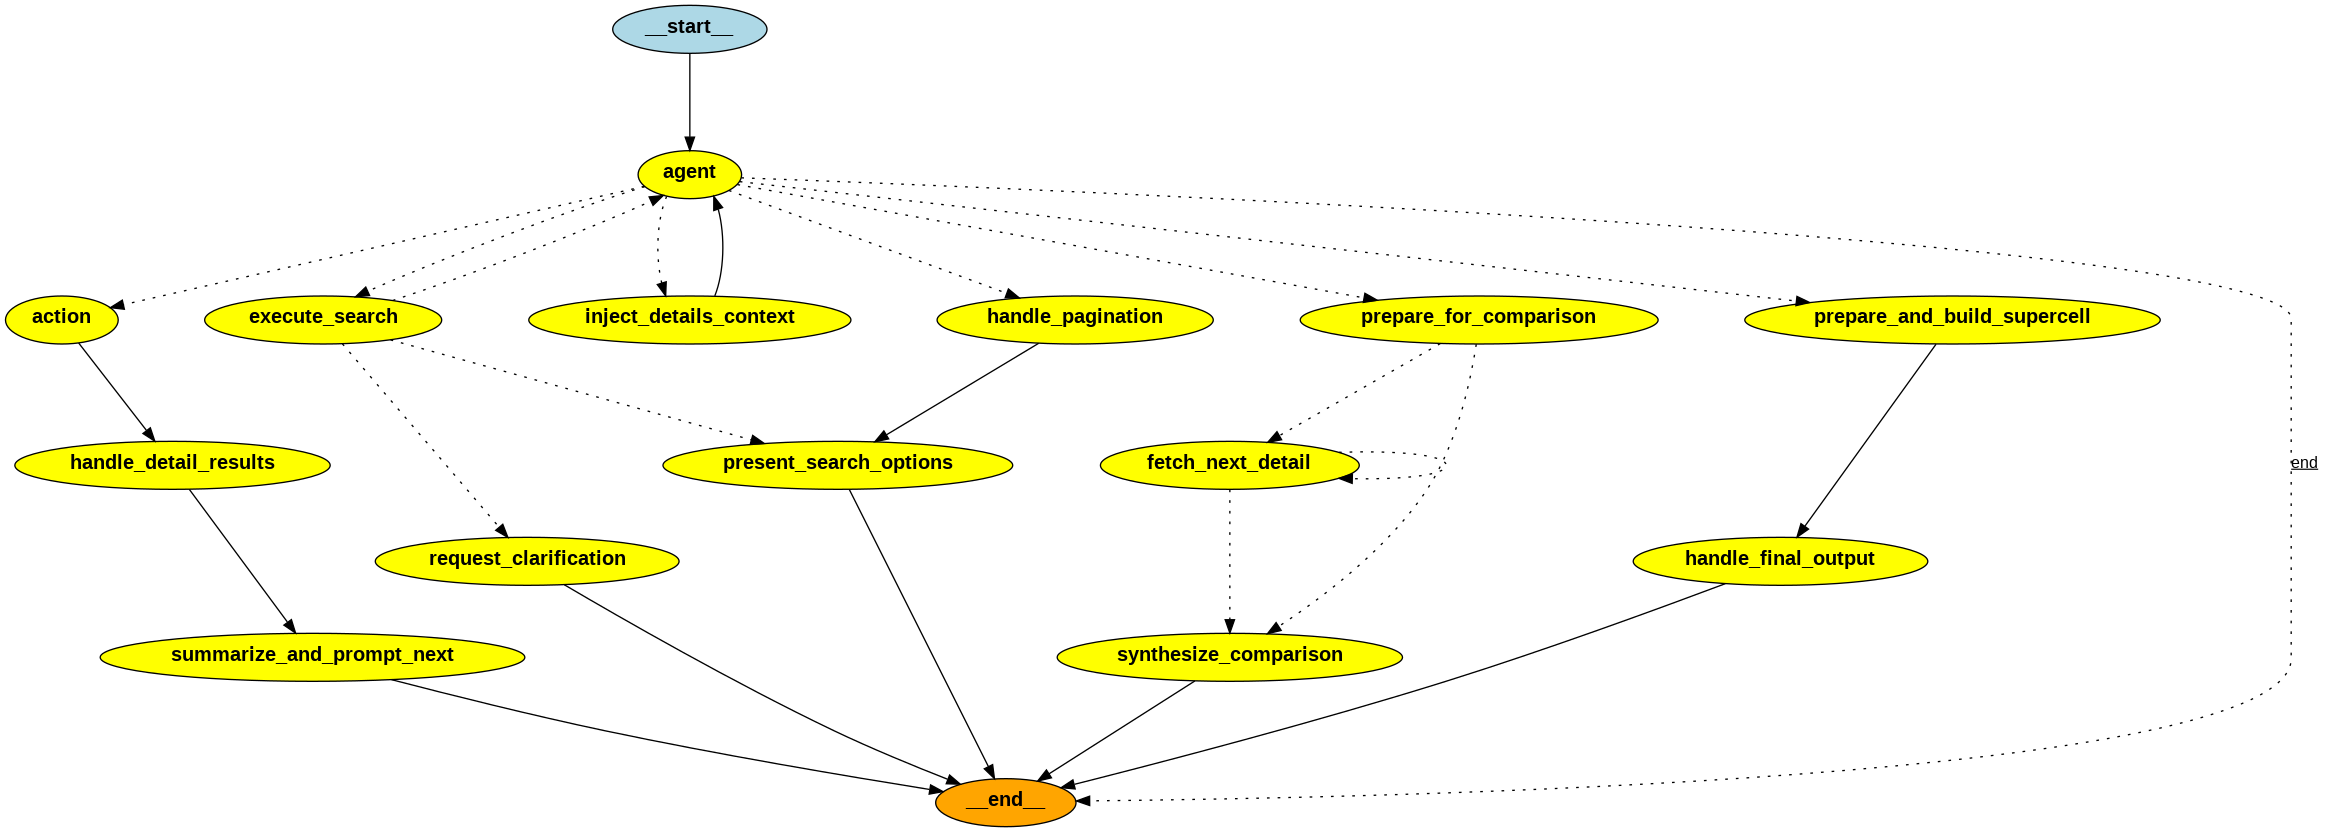

In [ ]:
from IPython.display import Image

# Now we can generate the visualization. The .get_graph() method provides access
# to the graph's structure, and .draw_png() renders it as a PNG image.
graph_image = app.get_graph().draw_png()

# Display the image in the notebook output.
Image(graph_image)

## 9. Running the Agent

This final cell brings the agent to life. It sets up an interactive loop that allows you to chat with the MatSci-Agent.

**How it works:**
1.  Initializes a persistent `conversation_state` object to maintain memory across the entire chat session.
2.  Enters a `while True` loop to continuously listen for user input.
3.  Appends the user's message to the state.
4.  Invokes the compiled LangGraph `app` with the current state.
5.  The agent runs through its graph (thinking, routing, executing tools) until it reaches an endpoint.
6.  The final, updated state is returned from the `app.invoke` call.
7.  We extract the agent's last message to display to the user.
8.  Crucially, we update our main `conversation_state` with the returned state, ensuring the agent remembers what happened in the next turn.
9.  The loop continues until the user types a command like 'exit' or 'stop'.

In [ ]:
import pprint

# --- We will manage the full state of the conversation here ---
conversation_state = GraphState(
    messages=[],
    detailed_material_data={}, # Initialize with an empty dictionary
    final_output="",
    search_query={},
    full_search_results=[],
    search_offset=0,
    page_size=10
)

fast_goodbye_phrases = [
    "exit", "quit", "goodbye", "bye", "stop"
]

print("--- MatSci-Agent is ready. Type 'exit', 'thanks', etc. to end the conversation. ---\\n")

while True:
    try:
        user_input = input("You: ")
        if user_input.lower() in fast_goodbye_phrases:
            print("Agent: Goodbye!\n--- Conversation ended. ---\n")
            break

        # Add the user's message to the state's message list
        conversation_state['messages'].append(HumanMessage(content=user_input))

        # Invoke the agent with the entire, persistent state object
        config = {"recursion_limit": 50}

        # The 'response_state' is the complete, updated state after the agent's turn.
        response_state = app.invoke(conversation_state, config=config)

        # The agent's display message is the last one in the list.
        agent_response_message = response_state['messages'][-1]

        # The agent's response content might be a string or a list of dicts.
        agent_content = ""
        if isinstance(agent_response_message.content, list) and len(agent_response_message.content) > 0:
            # Handle the new format: [{'type': 'text', 'text': '...'}]
            agent_content = agent_response_message.content[0].get('text', '')
        elif isinstance(agent_response_message.content, str):
            # Handle the standard string format
            agent_content = agent_response_message.content

        # IMPORTANT: Update our loop's state with the new state from the agent run.
        conversation_state = response_state

        print(f"Agent: {agent_content}")

        # Check for unrecoverable errors to end the conversation
        if "error" in agent_content.lower() or "i'm sorry, i couldn't" in agent_content.lower():
            if response_state.get('final_output') and "error" in response_state['final_output'].lower():
                 print("--- Agent reported an unrecoverable error. Ending conversation. ---\n")
                 break

    except Exception as e:
        print(f"An error occurred: {e}")
        break

--- MatSci-Agent is ready. Type 'exit', 'thanks', etc. to end the conversation. ---\n
You: Search for FeO
---NODE: AGENT (Thinking)---
---ROUTER: After Agent---
Decision: Call tool 'search_materials_project'
---NODE: EXECUTE SEARCH---
--- Searching Materials Project with args: {'formula': 'FeO'} ---


Retrieving SummaryDoc documents:   0%|          | 0/18 [00:00<?, ?it/s]

Successfully parsed 18 results.
---ROUTER: After Search---
Decision: Multiple results found, presenting options.
---NODE: PRESENT OPTIONS---
Agent: Showing results 1-10 of 18 total materials.
Please choose one by number:
1. FeO (ID: mp-1244983) - Band Gap: 0.29 eV
2. FeO (ID: mp-1245001) - Band Gap: 0.05 eV
3. FeO (ID: mp-1245168) - Band Gap: 0.05 eV
4. FeO (ID: mp-1178232) - Band Gap: 0.00 eV
5. FeO (ID: mp-1274279) - Band Gap: 1.82 eV
6. FeO (ID: mp-756436) - Band Gap: 0.95 eV
7. FeO (ID: mp-753682) - Band Gap: 0.00 eV
8. FeO (ID: mp-1181437) - Band Gap: 1.89 eV
9. FeO (ID: mp-715262) - Band Gap: 0.00 eV
10. FeO (ID: mp-1283030) - Band Gap: 1.80 eV

You can also navigate the results:
- Type 'next' to see the next page.
- Type 'show 20' or 'size 5' to change the number of results per page.
- Type 'skip 50' to jump 50 results ahead.
- Type 'go to page _' to jump to a specific page.
- Type 'start' or 'end' to go to the beginning or end of the list.
You: 1
---NODE: AGENT (Thinking)---
--

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

---NODE: PARSE DETAIL RESULTS---
---NODE: SUMMARIZE AND PROMPT NEXT---
Agent: I have the details for FeO (space group: P1). What would you like to do next? You can ask me to:
1. **Build a supercell** (e.g., 'build a 2x2x2 cell')
2. **Show the full details**
You: details
---NODE: AGENT (Thinking)---
---ROUTER: After Agent---
Decision: No tool call or special route needed. End of turn.
Agent: Here are the full details for FeO (mp-1244983):

**Material ID:** mp-1244983
**Formula:** FeO
**Band Gap:** 0.29 eV
**Symmetry:**
  - Space Group Number: 1
  - Space Group Symbol: P1
**Unit Cell:**
  - a = 10.659 Å
  - b = 10.457 Å
  - c = 9.945 Å
  - α = 93.71°
  - β = 87.57°
  - γ = 98.78°
**Atomic Sites:** This material has 80 atomic sites.
  - Fe at (0.115, 0.856, 0.106)
  - Fe at (0.238, 0.646, 0.834)
  - Fe at (0.998, 0.058, 0.843)
  - ... (and 77 more sites)

What would you like to do next? You can ask me to:
1. **Build a supercell** (e.g., 'build a 2x2x2 cell')
2. **Search for another materi

1. la funcion de construcción de muestra es solo un placeholder por ahora, me falta implementarla ahora que ya el agente es estable.

2. Cuando eso funcione, podriamos revisar hacer que el LLM ayude con los routers para que no sea necesario ser tan estatico con las palabras que los activan.
